In [40]:
from splitters import k_fold_edge_split
from dataset_loader import load_dataframes
from model import Net
from utils import train_model, device_finder, train_model_on_folds, predict_edges
from torch_geometric.utils import train_test_split_edges
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
from torch_geometric.data import Data
import numpy as np

warnings.simplefilter(action='ignore', category=FutureWarning)

In [41]:
final_dt_df, final_w2v_df, final_nv_df, final_fin_df, final_in_df, final_se_df, all_df = load_dataframes()

In [42]:
all_edges = []

print(all_df.shape)

for edge in all_df.values:
    if list(edge) not in all_edges and [edge[1], edge[0]] not in all_edges:
        all_edges.append(list(edge))
        all_edges.append([edge[1], edge[0]])

print(len(all_edges))

(2716, 2)
3732


In [43]:
# loading all edges of undirected graph

x_nv = final_nv_df.iloc[:, :128]
x_nv = np.array(x_nv, dtype=np.float32)

nodes_nv_list = list()
nodes_nv_dict = dict()

count = 0
for x in final_nv_df.values[:, 128:129]:
    nodes_nv_dict[str(x.squeeze())] = count
    count+=1
    nodes_nv_list.append(str(x.squeeze()))

edges_nv = list()
for edge in all_edges:
    if edge[0] in nodes_nv_list and edge[1] in nodes_nv_list:
        edges_nv.append([nodes_nv_dict[edge[0]], nodes_nv_dict[edge[1]]])
nodes_nv = list(nodes_nv_dict.values())
nodes_nv = torch.from_numpy(np.array(nodes_nv))
edges_nv = torch.from_numpy(np.array(edges_nv))
x_nv = torch.from_numpy(np.array(x_nv))

data_nv = Data(x=x_nv, edge_index=edges_nv.T)
data_nv

Data(x=[752, 128], edge_index=[2, 3406])

/home/sina/anaconda3/envs/pyg/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 000, Loss: 0.743240, Val: 0.676367, Test: 0.665744
Epoch: 100, Loss: 0.418333, Val: 0.964983, Test: 0.965398


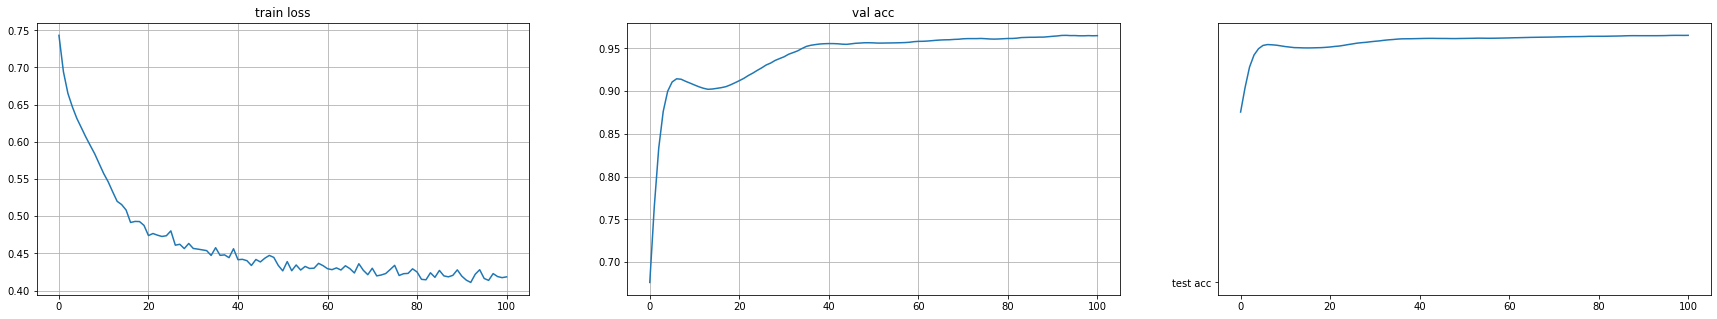

In [44]:
data = train_test_split_edges(data_nv, val_ratio=0.1, test_ratio=0.1)

device = device_finder()

# print(folds[0])
in_channels = data.num_features
hid_channels = 128
out_channels = 64

model = Net(in_channels=in_channels, hid_channels=hid_channels, out_channels=out_channels).to(device)
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.0005)


train_model(model, optimizer, data, 101, index=1)

# train_loss, val_acc, test_acc, model = train_model_on_folds(folds=folds, num_epochs=101, index=7, in_channels=in_channels, hid_channels=hid_channels, out_channels=out_channels, device=device, model_class=Net, lr=0.0005)


In [ ]:
z = model.encode(data_nv.x, data_nv.edge_index, index=7)
final_edge_index, prob_adj = model.decode_all(z)
scaler = MinMaxScaler()
prob_adj = prob_adj.detach().numpy()
prob_adj = scaler.fit_transform(prob_adj)
a = np.array(list((prob_adj > 0.8).nonzero())).T

correct = 0
c_edges = np.array(data_nv.edge_index.T)
for edge in a:
    edge = np.array(edge)
    if edge in c_edges:
        correct += 1

print(correct)
print(data_nv.edge_index.shape[1])

Epoch: 100, Train Loss: 0.451391, Val Acc: 0.981557, Test Acc: 0.980384


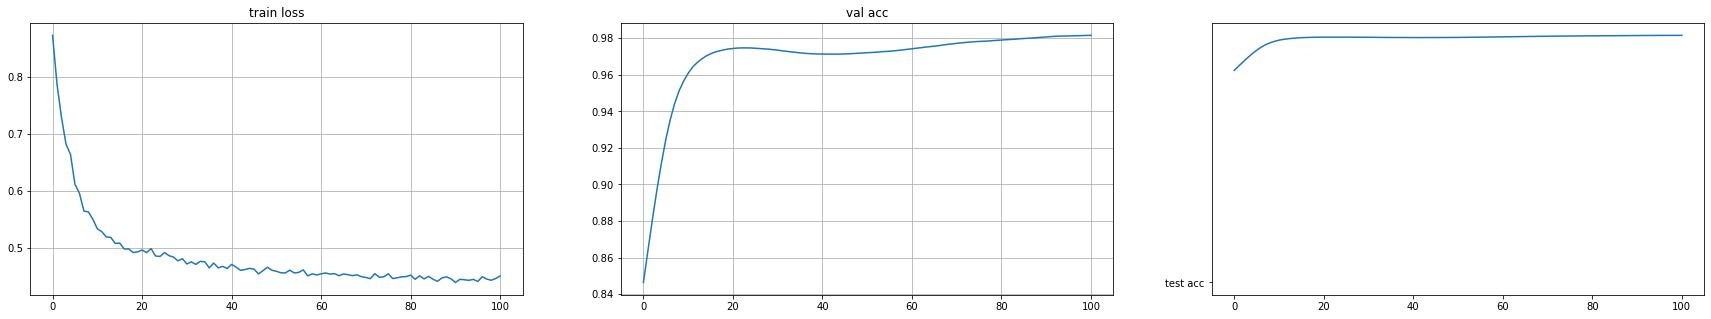

Epoch: 100, Train Loss: 0.414480, Val Acc: 0.980235, Test Acc: 0.978538


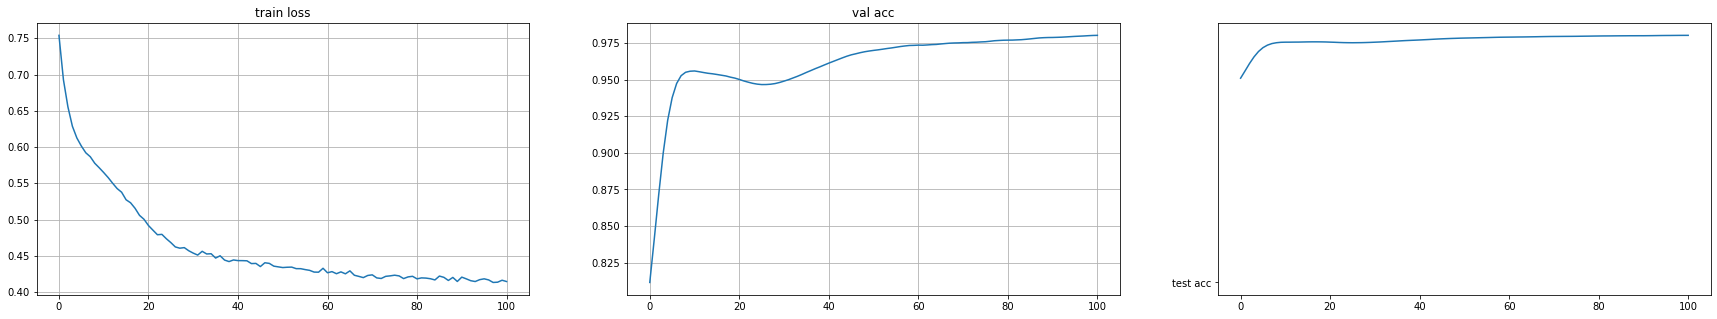

KeyboardInterrupt: 

In [39]:
folds = k_fold_edge_split(data_nv, only_upper_triangular_portion=False)

device = device_finder()

in_channels = folds[0].num_features
hid_channels = 128
out_channels = 64

t_list = []
v_list = []
te_list = []

for index in range(7, 14):
    train_loss, val_acc, test_acc, model = train_model_on_folds(folds=folds, num_epochs=101, index=index, in_channels=in_channels, hid_channels=hid_channels, out_channels=out_channels, device=device, model_class=Net, lr=0.0005, verbose=0)
    t_list.append(train_loss)
    v_list.append(val_acc)
    te_list.append(test_acc)

for i in range(len(t_list)):
    loss_ave = np.average(t_list[i])
    val_acc_ave = np.average(v_list[i])
    test_acc_ave = np.average(te_list[i])

model_layers = [1, 2, 3, 4, 5, 11, 21]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
for i in range(len(t_list)):
    plt.plot(t_list[i], label=f'{model_layers[i]} hid layers')
plt.legend()
plt.title('train loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(15, 12))
for i in range(len(v_list)):
    plt.plot(v_list[i], label=f'{model_layers[i]} hid layers')
plt.legend()
plt.title('val acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.figure(figsize=(15, 12))
for i in range(len(te_list)):
    plt.plot(te_list[i], label=f'{model_layers[i]} hid layers')
plt.legend()
plt.title('test acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

t_loss_ave = []
v_ave = []
t_ave = []

top = 100

for i in range(len(v_list)):
    t_loss_ave.append(np.average(t_list[i][:top]))
    v_ave.append(np.average(v_list[i][:top]))
    t_ave.append(np.average(te_list[i][:top]))

plot_layers_curve(model_layers, t_loss_ave, v_ave, t_ave)

t_loss_last = []
v_last = []
te_last = []
last = 100
for i in range(len(v_list)):
    t_loss_last.append(t_list[i][last])
    v_last.append(v_list[i][last])
    te_last.append(te_list[i][last])

plot_layers_curve(model_layers, t_loss_last, v_last, te_last)

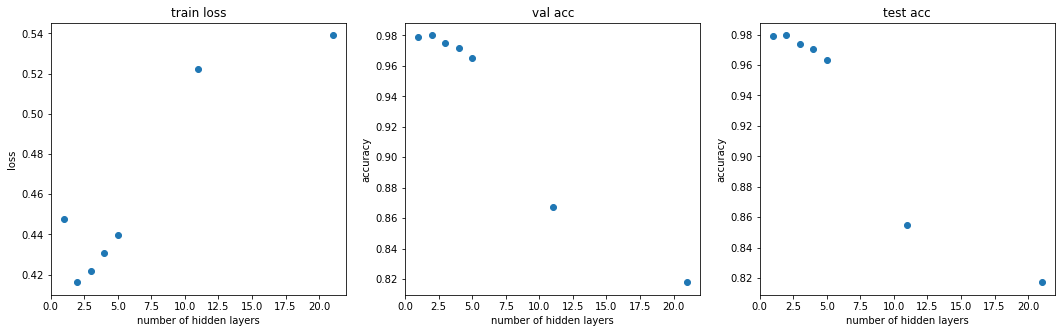

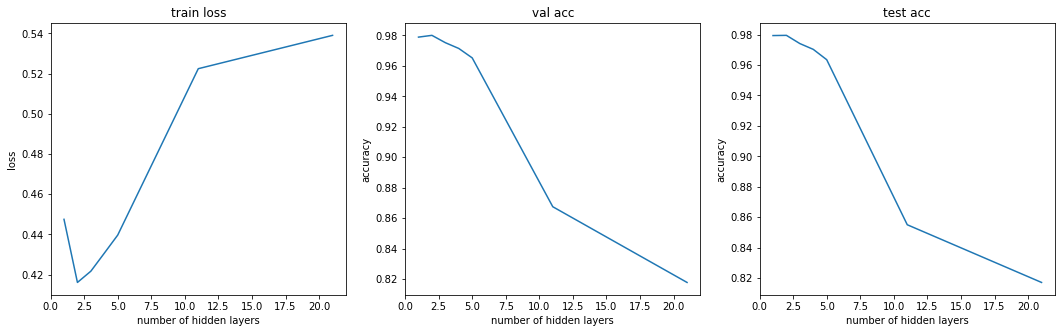

In [14]:
t_loss_last = []
v_last = []
te_last = []

top = 100

# loss_ave = np.average(t_list[i])
# val_acc_ave = np.average(v_list[i])
# test_acc_ave = np.average(te_list[i])

for i in range(len(v_list)):
    t_loss_last.append(t_list[i][99])
    v_last.append(v_list[i][99])
    te_last.append(te_list[i][99])

plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.scatter(model_layers, t_loss_last)
plt.title('train loss')
plt.xlabel('number of hidden layers')
plt.ylabel('loss')

plt.subplot(132)
plt.scatter(model_layers, v_last)
plt.title('val acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.subplot(133)
plt.scatter(model_layers, te_last)
plt.title('test acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.show() 

############################################################

plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.plot(model_layers, t_loss_last)
plt.title('train loss')
plt.xlabel('number of hidden layers')
plt.ylabel('loss')

plt.subplot(132)
plt.plot(model_layers, v_last)
plt.title('val acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.subplot(133)
plt.plot(model_layers, te_last)
plt.title('test acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.show() 

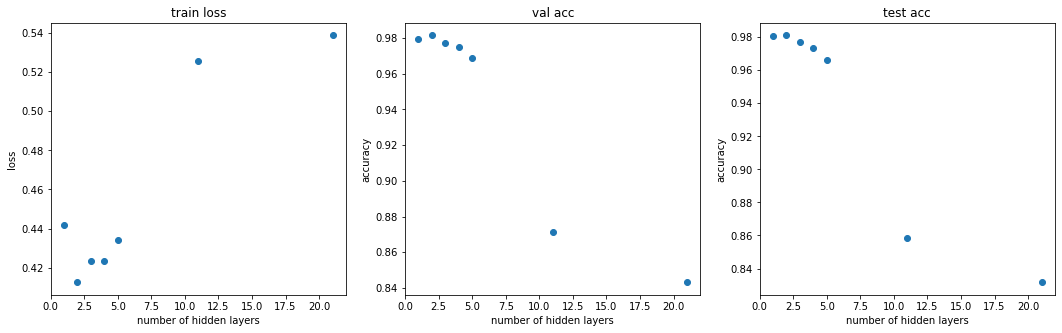

In [15]:
train_loss_last = []
val_last = []
test_last = []

top = 100

for i in range(len(val_list)):
    train_loss_last.append(train_list[i][99])
    val_last.append(val_list[i][99])
    test_last.append(test_list[i][99])

plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.scatter(model_layers, train_loss_last)
plt.title('train loss')
plt.xlabel('number of hidden layers')
plt.ylabel('loss')

plt.subplot(132)
plt.scatter(model_layers, val_last)
plt.title('val acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.subplot(133)
plt.scatter(model_layers, test_last)
plt.title('test acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.show() 

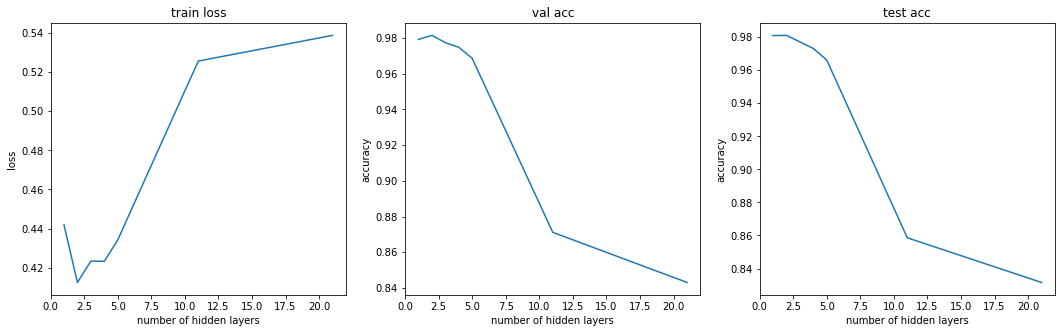

In [16]:
plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.plot(model_layers, train_loss_last)
plt.title('train loss')
plt.xlabel('number of hidden layers')
plt.ylabel('loss')

plt.subplot(132)
plt.plot(model_layers, val_last)
plt.title('val acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.subplot(133)
plt.plot(model_layers, test_last)
plt.title('test acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.show()

(752, 32)
Epoch: 100, Train Loss: 0.427424, Val Acc: 0.980974, Test Acc: 0.983054


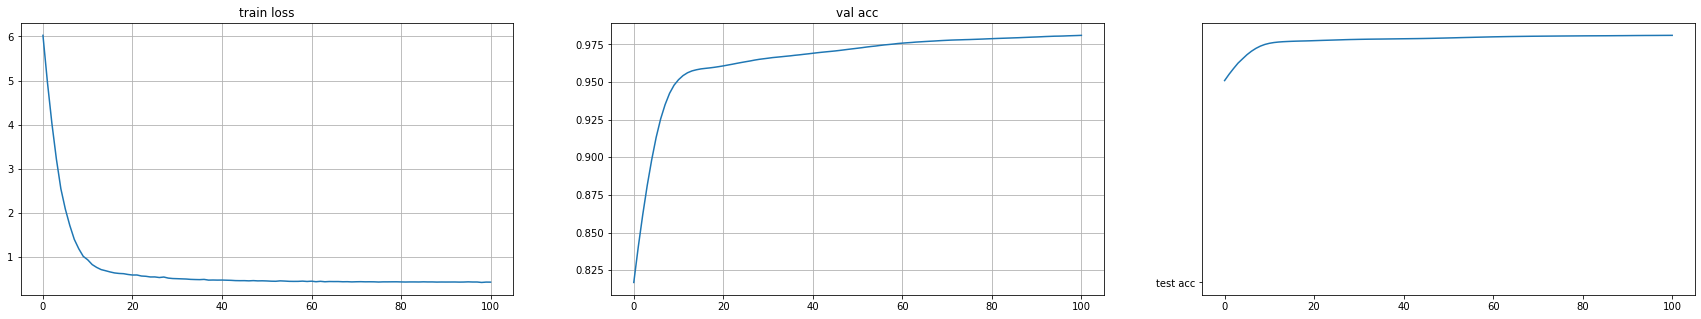

In [17]:
# Scale data before applying PCA
scaling=StandardScaler()
 
df1 = x_nv

# Use fit and transform method
scaling.fit(df1)
Scaled_data=scaling.transform(df1)
 
# Set the n_components=3
principal=PCA(n_components=32)
principal.fit(Scaled_data)
x=principal.transform(Scaled_data)
 
# Check the dimensions of data after PCA
print(x.shape)

x = torch.from_numpy(x)

x = x.float()
data = Data(x=x, edge_index=edges_nv.T)

folds = k_fold_edge_split(data, only_upper_triangular_portion=False)

device = device_finder()

in_channels = folds[0].num_features
hid_channels = 128
out_channels = 64

train_loss, val_acc, test_acc, model = train_model_on_folds(folds=folds, num_epochs=101, index=8, in_channels=in_channels,
                                                             hid_channels=hid_channels, out_channels=out_channels, device=device,
                                                             model_class=Net, lr=0.0005, verbose=0)

In [7]:
# Scale data before applying PCA
scaling=StandardScaler()
 
df1 = x_nv

# Use fit and transform method
scaling.fit(df1)
Scaled_data=scaling.transform(df1)
 
# Set the n_components=3
principal=PCA(n_components=32)
principal.fit(Scaled_data)
x=principal.transform(Scaled_data)
 
# Check the dimensions of data after PCA
print(x.shape)

x = torch.from_numpy(x)

x = x.float()
data = Data(x=x, edge_index=edges_nv.T)

# folds = k_fold_edge_split(data, only_upper_triangular_portion=False)

(752, 32)


Epoch: 100, Train Loss: 1.360928, Val Acc: 0.972293, Test Acc: 0.972951


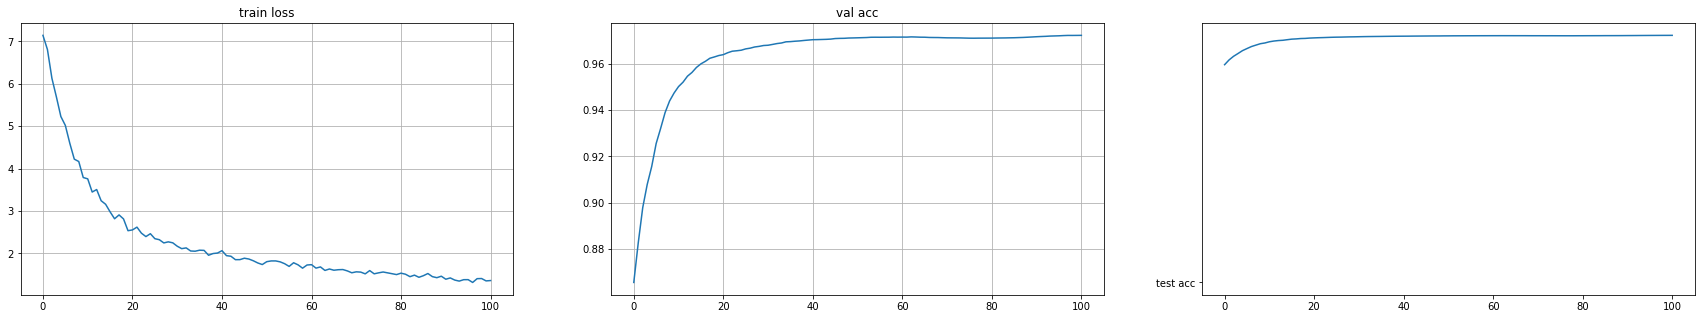

Epoch: 100, Train Loss: 0.422685, Val Acc: 0.980362, Test Acc: 0.984908


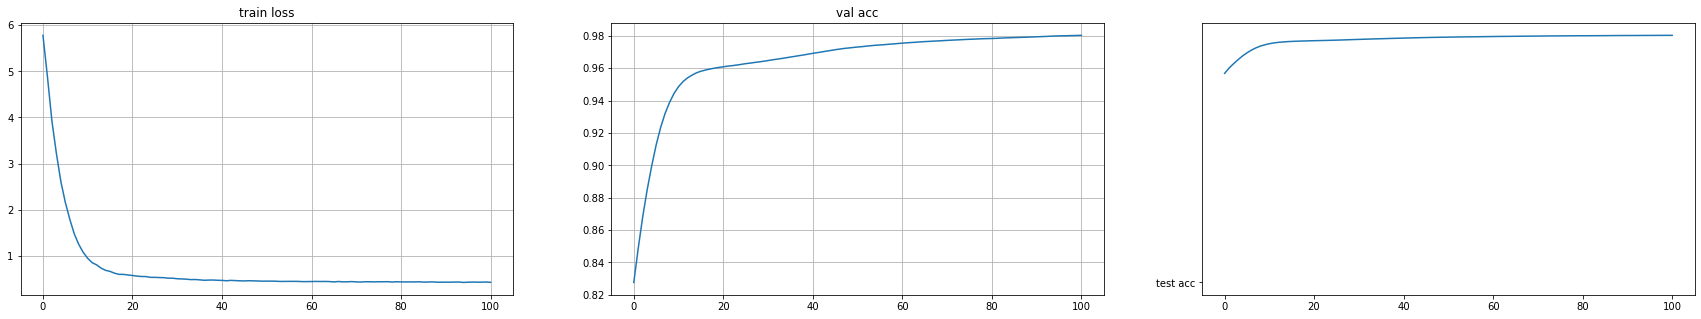

Epoch: 100, Train Loss: 0.427495, Val Acc: 0.973652, Test Acc: 0.974216


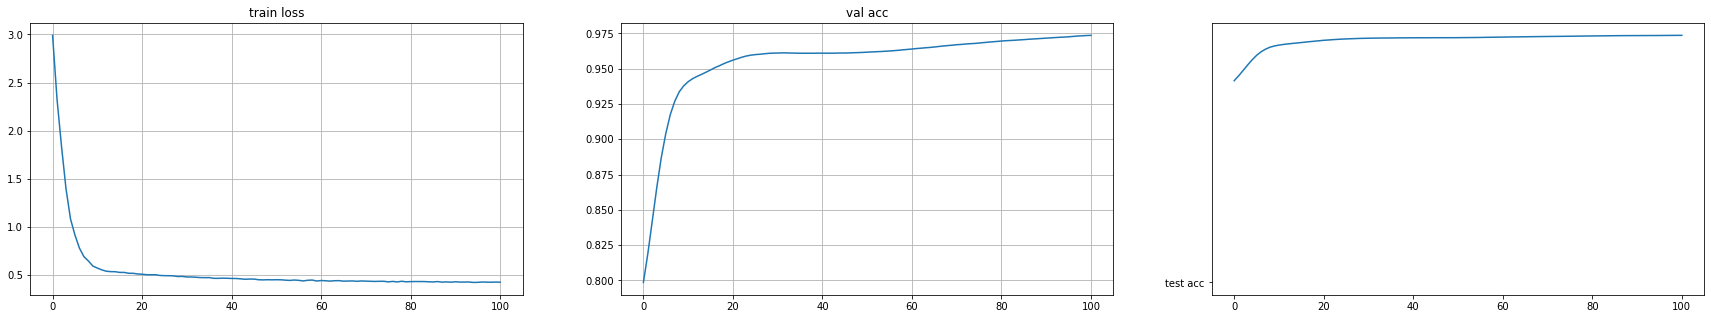

Epoch: 100, Train Loss: 0.428138, Val Acc: 0.968234, Test Acc: 0.972796


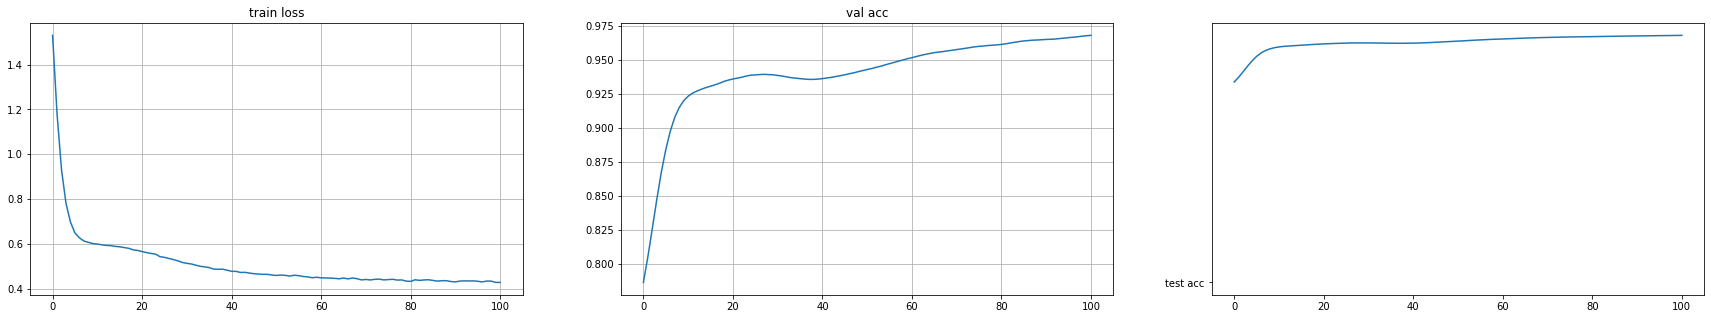

Epoch: 100, Train Loss: 0.439060, Val Acc: 0.962273, Test Acc: 0.965202


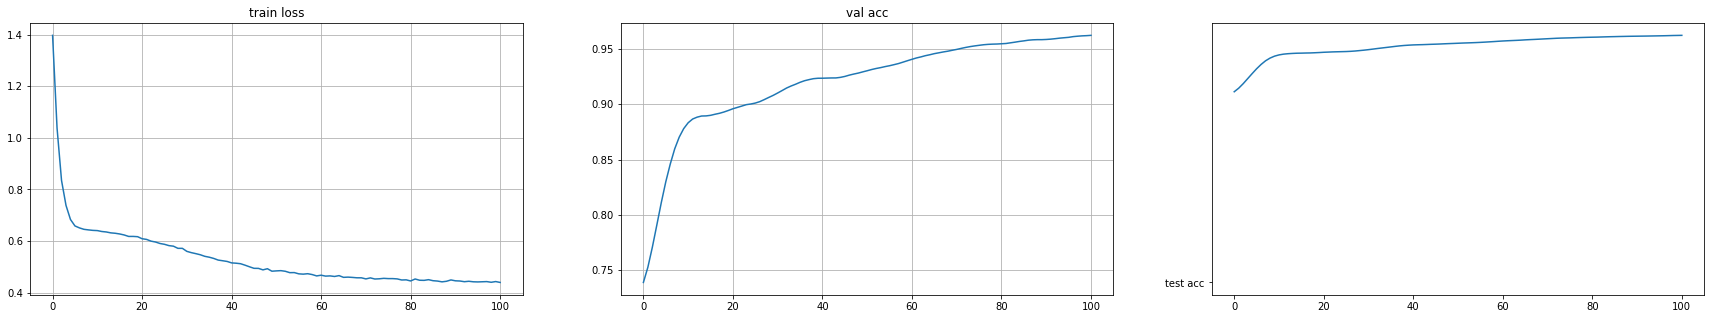

Epoch: 100, Train Loss: 0.481921, Val Acc: 0.922360, Test Acc: 0.927472


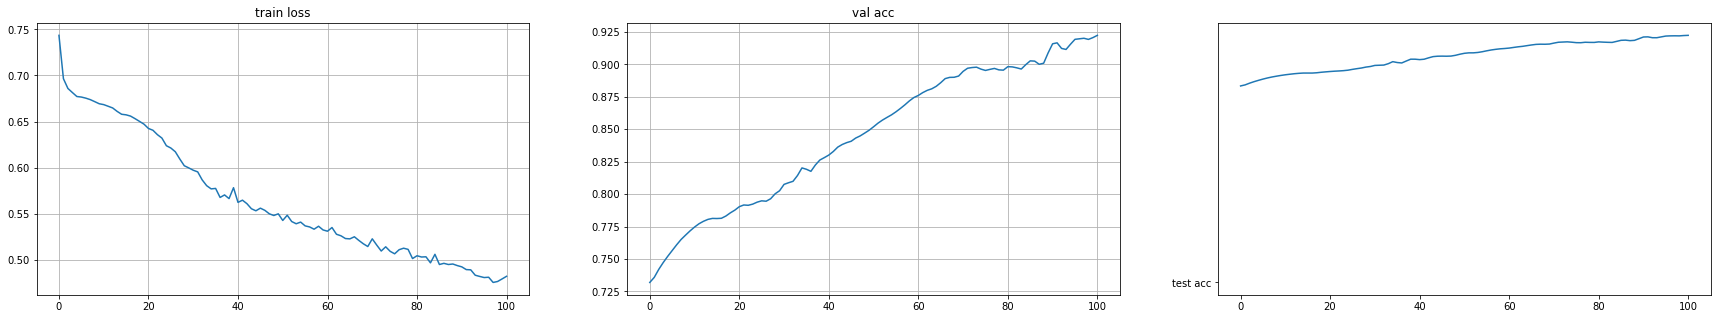

Epoch: 100, Train Loss: 0.548693, Val Acc: 0.818878, Test Acc: 0.825948


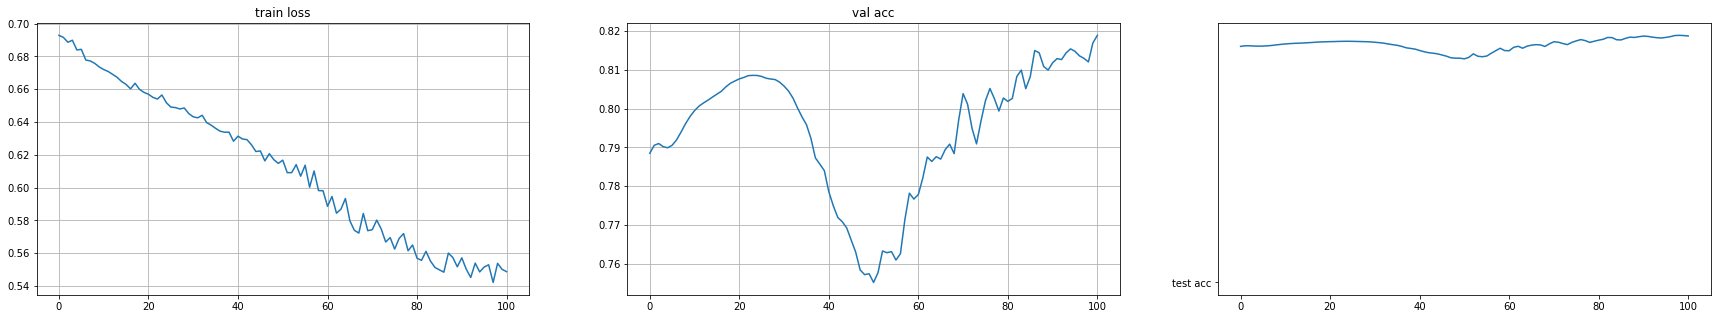

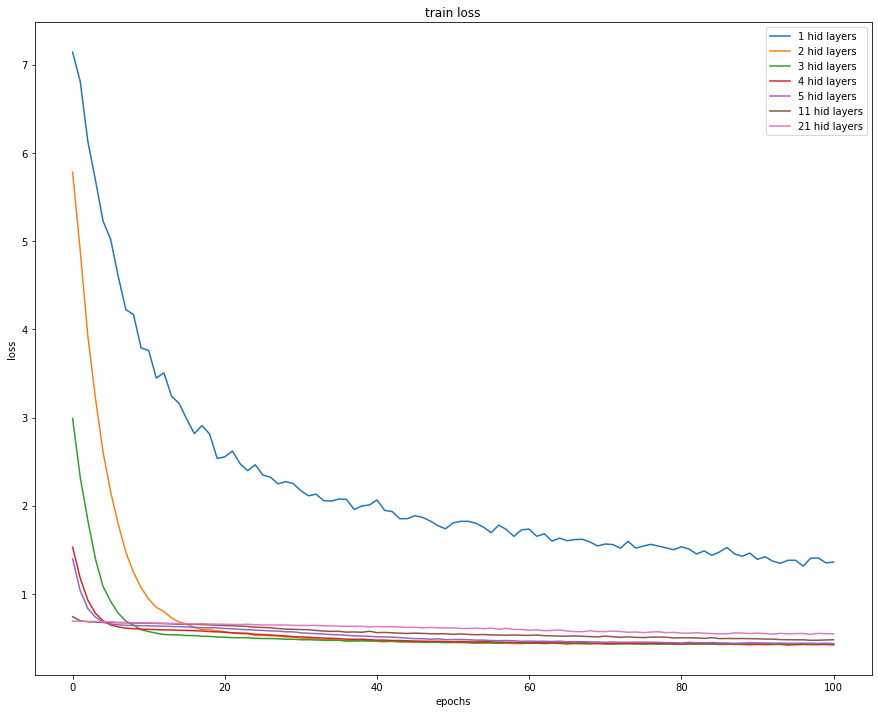

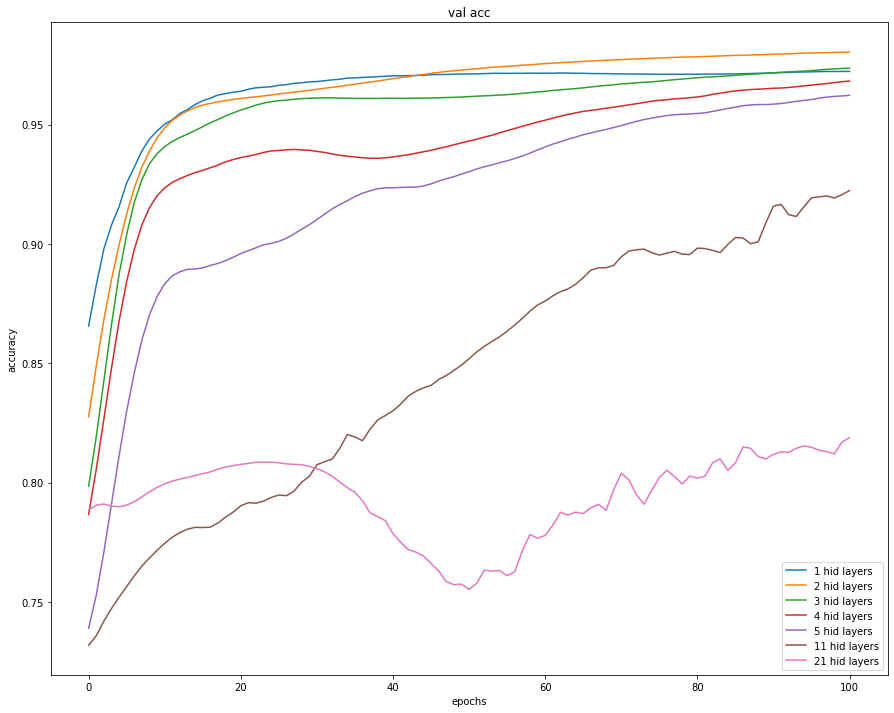

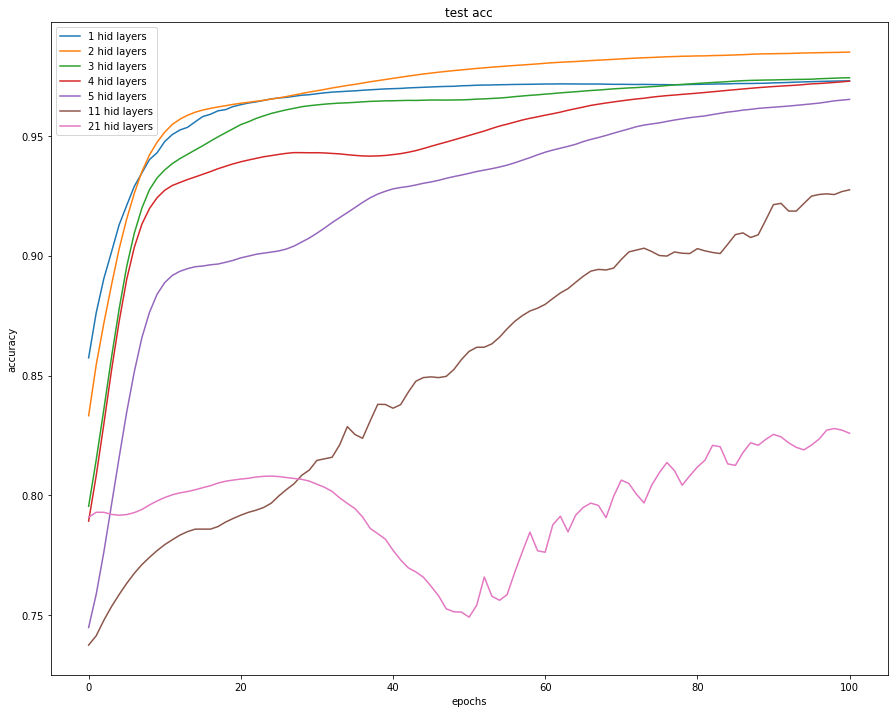

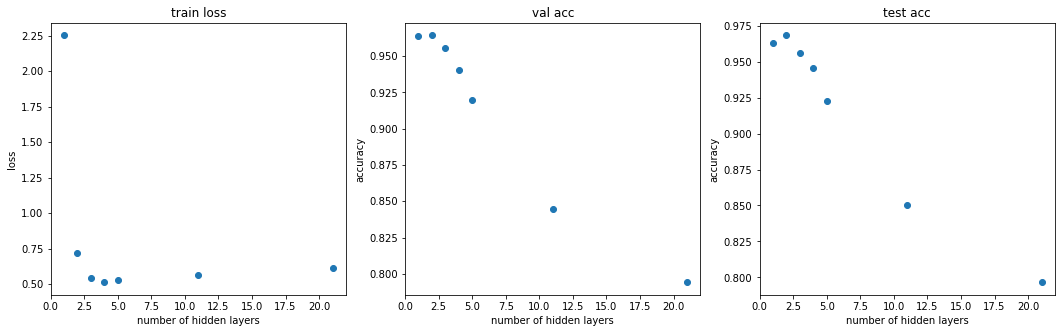

In [8]:
folds = k_fold_edge_split(data, only_upper_triangular_portion=False)

device = device_finder()

in_channels = folds[0].num_features
hid_channels = 128
out_channels = 64

train_list = []
val_list = []
test_list = []

for index in range(7, 14):
    train_loss, val_acc, test_acc, model = train_model_on_folds(folds=folds, num_epochs=101, index=index, in_channels=in_channels, hid_channels=hid_channels, out_channels=out_channels, device=device, model_class=Net, lr=0.0005, verbose=0)
    train_list.append(train_loss)
    val_list.append(val_acc)
    test_list.append(test_acc)

for i in range(len(train_list)):
    loss_ave = np.average(train_list[i])
    val_acc_ave = np.average(val_list[i])
    test_acc_ave = np.average(test_list[i])

model_layers = [1, 2, 3, 4, 5, 11, 21]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
for i in range(len(train_list)):
    plt.plot(train_list[i], label=f'{model_layers[i]} hid layers')
plt.legend()
plt.title('train loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.figure(figsize=(15, 12))
for i in range(len(val_list)):
    plt.plot(val_list[i], label=f'{model_layers[i]} hid layers')
plt.legend()
plt.title('val acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.figure(figsize=(15, 12))
for i in range(len(test_list)):
    plt.plot(test_list[i], label=f'{model_layers[i]} hid layers')
plt.legend()
plt.title('test acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

train_loss_ave = []
val_ave = []
test_ave = []

top = 100

for i in range(len(val_list)):
    train_loss_ave.append(np.average(train_list[i][:top]))
    val_ave.append(np.average(val_list[i][:top]))
    test_ave.append(np.average(test_list[i][:top]))

plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.scatter(model_layers, train_loss_ave)
plt.title('train loss')
plt.xlabel('number of hidden layers')
plt.ylabel('loss')

plt.subplot(132)
plt.scatter(model_layers, val_ave)
plt.title('val acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.subplot(133)
plt.scatter(model_layers, test_ave, )
plt.title('test acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.show() 


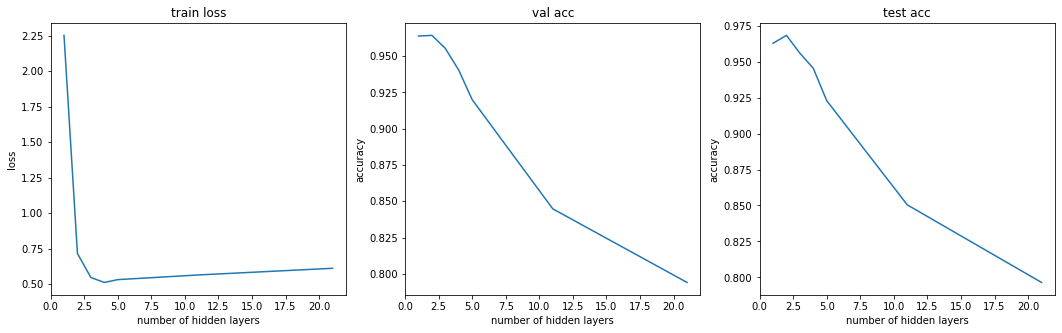

In [29]:
plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.plot(model_layers, train_loss_ave)
plt.title('train loss')
plt.xlabel('number of hidden layers')
plt.ylabel('loss')

plt.subplot(132)
plt.plot(model_layers, val_ave)
plt.title('val acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.subplot(133)
plt.plot(model_layers, test_ave, )
plt.title('test acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.show() 

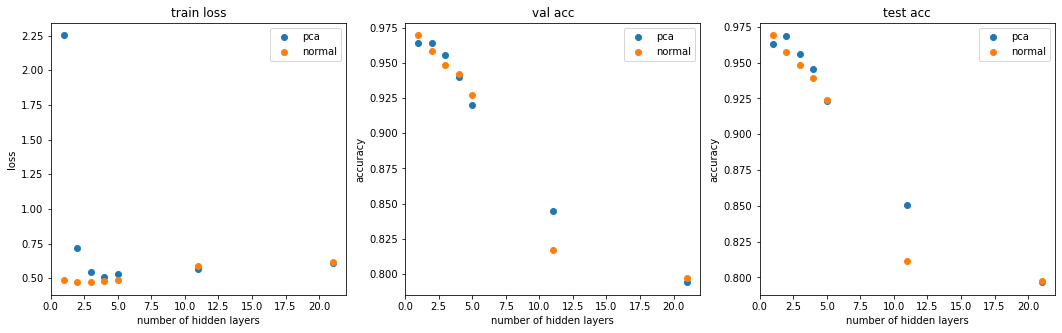

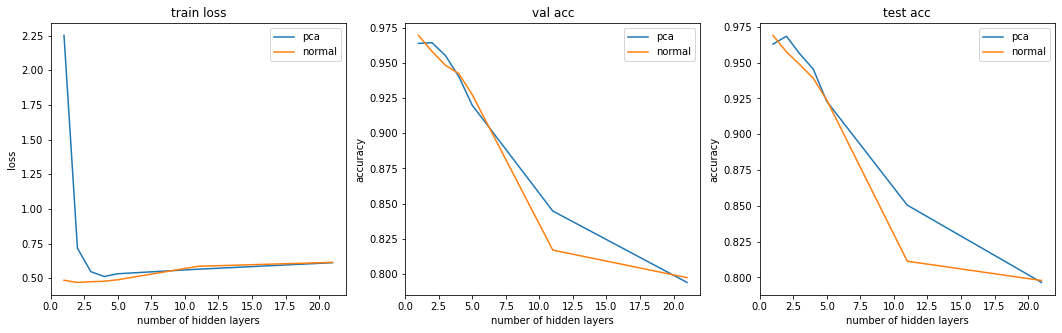

In [28]:
plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.scatter(model_layers, train_loss_ave, label='pca')
plt.scatter(model_layers, t_loss_ave, label='normal')
plt.title('train loss')
plt.xlabel('number of hidden layers')
plt.ylabel('loss')
plt.legend()

plt.subplot(132)
plt.scatter(model_layers, val_ave, label='pca')
plt.scatter(model_layers, v_ave, label='normal')
plt.title('val acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(133)
plt.scatter(model_layers, test_ave, label='pca')
plt.scatter(model_layers, t_ave, label='normal')
plt.title('test acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')
plt.legend()

plt.show() 

########################################################

plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.plot(model_layers, train_loss_ave, label='pca')
plt.plot(model_layers, t_loss_ave, label='normal')
plt.title('train loss')
plt.xlabel('number of hidden layers')
plt.ylabel('loss')
plt.legend()

plt.subplot(132)
plt.plot(model_layers, val_ave, label='pca')
plt.plot(model_layers, v_ave, label='normal')
plt.title('val acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(133)
plt.plot(model_layers, test_ave, label='pca')
plt.plot(model_layers, t_ave, label='normal')
plt.title('test acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')
plt.legend()

plt.show() 

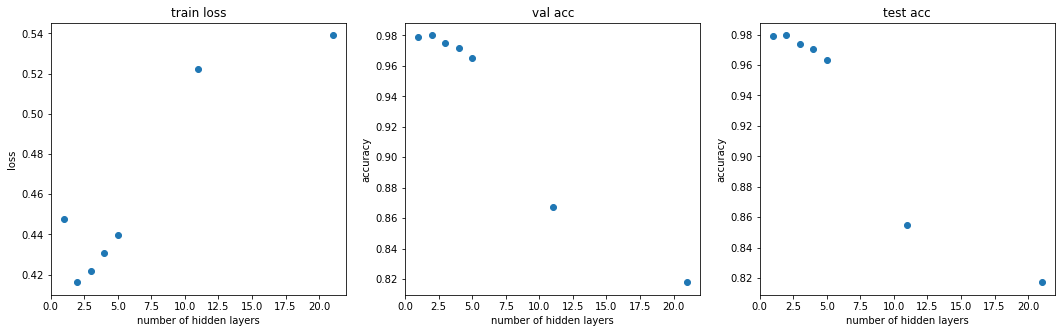

In [24]:
t_loss_last = []
v_last = []
te_last = []

top = 100

# loss_ave = np.average(t_list[i])
# val_acc_ave = np.average(v_list[i])
# test_acc_ave = np.average(te_list[i])

for i in range(len(v_list)):
    t_loss_last.append(t_list[i][99])
    v_last.append(v_list[i][99])
    te_last.append(te_list[i][99])

plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.scatter(model_layers, t_loss_last)
plt.title('train loss')
plt.xlabel('number of hidden layers')
plt.ylabel('loss')

plt.subplot(132)
plt.scatter(model_layers, v_last)
plt.title('val acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.subplot(133)
plt.scatter(model_layers, te_last)
plt.title('test acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.show() 

In [ ]:
v_

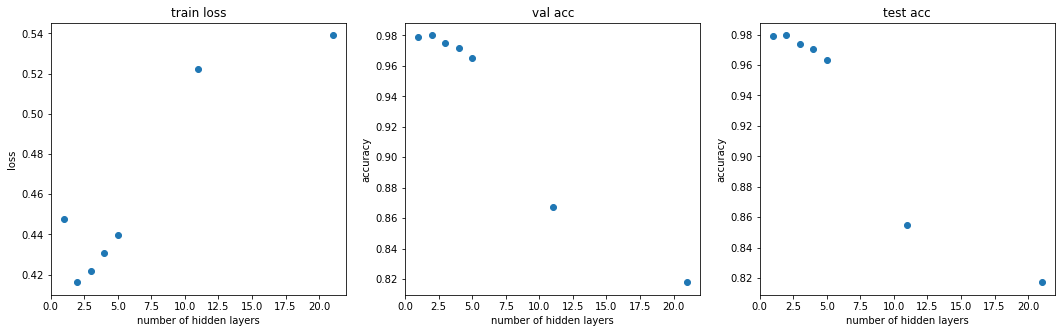

In [32]:
t_loss_last = []
v_last = []
te_last = []

top = 100

# loss_ave = np.average(t_list[i])
# val_acc_ave = np.average(v_list[i])
# test_acc_ave = np.average(te_list[i])

for i in range(len(v_list)):
    t_loss_last.append(t_list[i][99])
    v_last.append(v_list[i][99])
    te_last.append(te_list[i][99])

plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.scatter(model_layers, t_loss_last)
plt.title('train loss')
plt.xlabel('number of hidden layers')
plt.ylabel('loss')

plt.subplot(132)
plt.scatter(model_layers, v_last)
plt.title('val acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.subplot(133)
plt.scatter(model_layers, te_last)
plt.title('test acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.show() 

In [31]:
train_list
val_list
test_list

7

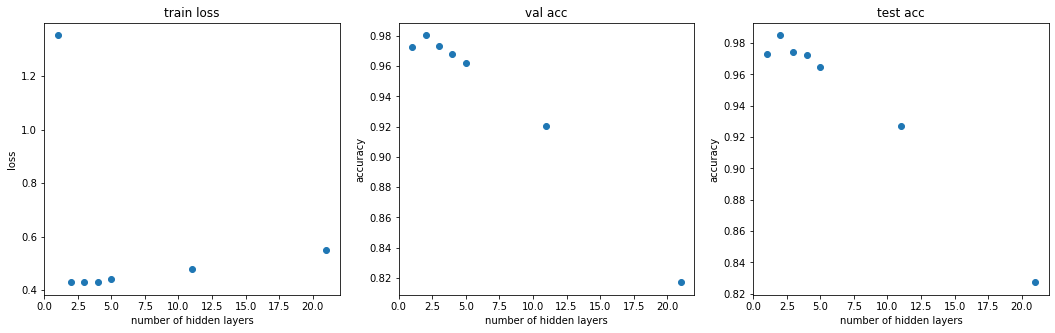

In [33]:
train_loss_last = []
val_last = []
test_last = []

top = 100

for i in range(len(v_list)):
    train_loss_last.append(train_list[i][99])
    val_last.append(val_list[i][99])
    test_last.append(test_list[i][99])

plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.scatter(model_layers, train_loss_last)
plt.title('train loss')
plt.xlabel('number of hidden layers')
plt.ylabel('loss')

plt.subplot(132)
plt.scatter(model_layers, val_last)
plt.title('val acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.subplot(133)
plt.scatter(model_layers, test_last)
plt.title('test acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')

plt.show() 

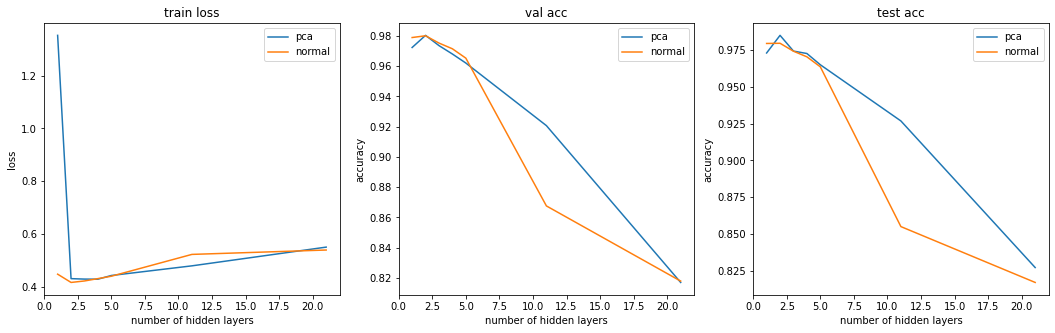

In [35]:
plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.plot(model_layers, train_loss_last, label='pca')
plt.plot(model_layers, t_loss_last, label='normal')
plt.title('train loss')
plt.xlabel('number of hidden layers')
plt.ylabel('loss')
plt.legend()

plt.subplot(132)
plt.plot(model_layers, val_last, label='pca')
plt.plot(model_layers, v_last, label='normal')
plt.title('val acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(133)
plt.plot(model_layers, test_last, label='pca')
plt.plot(model_layers, te_last, label='normal')
plt.title('test acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')
plt.legend()

plt.show() 

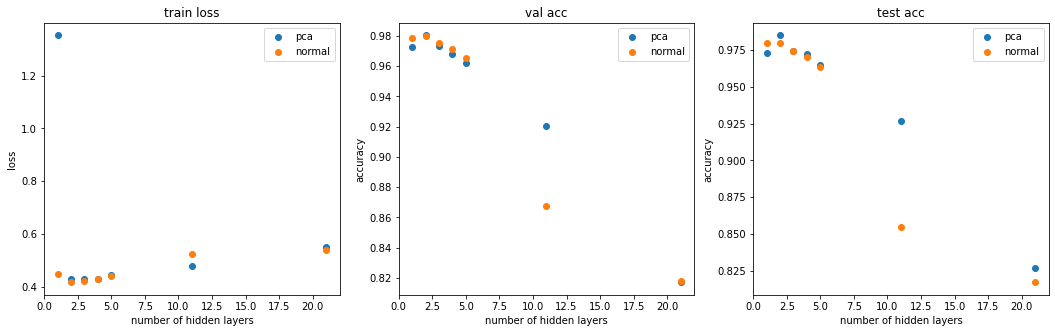

In [36]:
plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.scatter(model_layers, train_loss_last, label='pca')
plt.scatter(model_layers, t_loss_last, label='normal')
plt.title('train loss')
plt.xlabel('number of hidden layers')
plt.ylabel('loss')
plt.legend()

plt.subplot(132)
plt.scatter(model_layers, val_last, label='pca')
plt.scatter(model_layers, v_last, label='normal')
plt.title('val acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(133)
plt.scatter(model_layers, test_last, label='pca')
plt.scatter(model_layers, te_last, label='normal')
plt.title('test acc')
plt.xlabel('number of hidden layers')
plt.ylabel('accuracy')
plt.legend()

plt.show() 

In [37]:
folds

[Data(x=[752, 128], val_pos_edge_index=[2, 340], test_pos_edge_index=[2, 340], train_pos_edge_index=[2, 2726], train_neg_adj_mask=[752, 752], val_neg_edge_index=[2, 340], test_neg_edge_index=[2, 340]),
 Data(x=[752, 128], val_pos_edge_index=[2, 340], test_pos_edge_index=[2, 340], train_pos_edge_index=[2, 2726], train_neg_adj_mask=[752, 752], val_neg_edge_index=[2, 340], test_neg_edge_index=[2, 340]),
 Data(x=[752, 128], val_pos_edge_index=[2, 340], test_pos_edge_index=[2, 340], train_pos_edge_index=[2, 2726], train_neg_adj_mask=[752, 752], val_neg_edge_index=[2, 340], test_neg_edge_index=[2, 340]),
 Data(x=[752, 128], val_pos_edge_index=[2, 340], test_pos_edge_index=[2, 340], train_pos_edge_index=[2, 2726], train_neg_adj_mask=[752, 752], val_neg_edge_index=[2, 340], test_neg_edge_index=[2, 340]),
 Data(x=[752, 128], val_pos_edge_index=[2, 340], test_pos_edge_index=[2, 340], train_pos_edge_index=[2, 2726], train_neg_adj_mask=[752, 752], val_neg_edge_index=[2, 340], test_neg_edge_index=[